In [3]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
from tqdm import tqdm

# ----------------------------------------
# 1) Hyperparameters and device setup
# ----------------------------------------
device = "cuda:0"

epochs               = 50
batch_size           = 128
learning_rate        = 2e-4
image_size           = 28
num_channels         = 1
timesteps            = 1000
ema_decay            = 0.999
num_inference_steps  = 100
pc_corrector_steps   = 1
pc_gamma             = 0.1

In [4]:
# ----------------------------------------
# 2) Cosine β-schedule and helpers
# ----------------------------------------
def cosine_beta_schedule(T, s=0.008):
    steps = T + 1
    x = torch.linspace(0, T, steps)
    alphas_cumprod = torch.cos(((x/T + s)/(1+s)) * math.pi/2)**2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 1e-6, 0.999)

betas = cosine_beta_schedule(timesteps).to(device)                   # [T]
alphas = 1.0 - betas  # [T]
alphas_cumprod = torch.cumprod(alphas, dim=0)                      # [T]
alpha_cumprod_prev = torch.cat([
    torch.tensor([1.0], device=device, dtype=alphas_cumprod.dtype),
    alphas_cumprod[:-1]
], dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)                   # [T]
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)   # [T]
posterior_variance = betas * (1.0 - alpha_cumprod_prev) / (1.0 - alphas_cumprod)
posterior_variance = torch.cat([posterior_variance, betas[-1:]], dim=0)  # [T]

def get_index_from_list(vals, t, x_shape):
    out = vals.gather(0, t).reshape((t.shape[0],) + (1,)*(len(x_shape)-1))
    return out.to(device)

In [5]:
# ----------------------------------------
# 3) Sinusoidal time‐embedding
# ----------------------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb

In [6]:
# ----------------------------------------
# 4) A small U-Net for noise prediction
# ----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch)
        )
    def forward(self, x, t_emb):
        h = self.net[0:3](x)
        # add time embedding
        time_emb = self.time_mlp(t_emb)[..., None, None]
        h = h + time_emb
        return self.net[3:](h)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch, time_emb_dim)
    def forward(self, x, t):
        return self.conv(self.pool(x), t)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        # up: [B, in_ch, H, W] → [B, out_ch, 2H, 2W]
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        # conv now expects in_ch + out_ch channels (skip + up)
        self.conv = DoubleConv(in_ch + out_ch, out_ch, time_emb_dim)

    def forward(self, x, skip, t):
        x = self.up(x)                # [B, out_ch, 2H, 2W]
        x = torch.cat([x, skip], 1)   # [B, in_ch+out_ch, 2H, 2W]
        return self.conv(x, t)        # maps back to [B, out_ch, 2H, 2W]

class UNet(nn.Module):
    def __init__(self, time_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        self.inc  = DoubleConv(num_channels, 64,  time_emb_dim)
        self.down1= Down(64, 128, time_emb_dim)
        self.down2= Down(128, 128, time_emb_dim)
        self.up1  = Up(128, 64, time_emb_dim)
        self.up2  = Up(64, 64,  time_emb_dim)
        self.outc = nn.Conv2d(64, num_channels, 1)
    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        x1 = self.inc(x,        t_emb)
        x2 = self.down1(x1,     t_emb)
        x3 = self.down2(x2,     t_emb)
        x  = self.up1(x3,  x2,  t_emb)
        x  = self.up2(x,   x1,  t_emb)
        return self.outc(x)

In [7]:
# ----------------------------------------
# 5) EMA helper
# ----------------------------------------
class EMA:
    def __init__(self, model, decay):
        self.decay = decay
        self.shadow = {k: v.clone().detach() for k, v in model.state_dict().items()}
    def update(self, model):
        for k, v in model.state_dict().items():
            self.shadow[k] = self.decay * self.shadow[k] + (1. - self.decay) * v.clone().detach()
    def apply_shadow(self, model):
        model.load_state_dict(self.shadow)

In [8]:
# ----------------------------------------
# 6) Data loader
# ----------------------------------------
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.2MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
# ----------------------------------------
# 7) Model, optimizer, EMA
# ----------------------------------------
model = UNet().to(device)
ema   = EMA(model, ema_decay)
opt   = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# ----------------------------------------
# 8) Training loop
# ----------------------------------------
for epoch in range(epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for x0, _ in pbar:
        x0 = x0.to(device)

        # 1) sample random timesteps for each image
        t = torch.randint(0, timesteps, (x0.size(0),), device=device)

        # 2) sample noise and produce x_t
        noise = torch.randn_like(x0)
        sqrt_acp = get_index_from_list(sqrt_alphas_cumprod, t, x0.shape)
        sqrt_1macp = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x0.shape)
        x_t = sqrt_acp * x0 + sqrt_1macp * noise

        # 3) predict noise and compute variance‐weighted loss
        pred_noise = model(x_t, t)
        beta_t = get_index_from_list(betas, t, x0.shape)
        alpha_t = get_index_from_list(alphas, t, x0.shape)
        acp_t = get_index_from_list(alphas_cumprod, t, x0.shape)
        weight = (beta_t**2) / (alpha_t * (1 - acp_t))
        loss = (weight * F.mse_loss(pred_noise, noise, reduction="none")).mean()

        # 4) optimizer step
        opt.zero_grad(); loss.backward(); opt.step()
        ema.update(model)

        pbar.set_postfix(loss=loss.item())

    # save a checkpoint and a sample grid every few epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"ddpm_model_epoch{epoch+1}.pth")
        # sample images to visually monitor progress
        ema.apply_shadow(model)
        samples = []

        with torch.no_grad():
            x = torch.randn(16, num_channels, image_size, image_size, device=device)
            for i in reversed(range(0, num_inference_steps)):
                t_cur = torch.full((x.size(0),), i*(timesteps//num_inference_steps), device=device, dtype=torch.long)
                # predictor step
                eps = model(x, t_cur)
                beta = get_index_from_list(betas, t_cur, x.shape)
                sqrt1macp = get_index_from_list(sqrt_one_minus_alphas_cumprod, t_cur, x.shape)
                coeff = beta / sqrt1macp
                x = (1/torch.sqrt(get_index_from_list(alphas, t_cur, x.shape))) * (x - coeff * eps)
                # corrector (Langevin) step
                for _ in range(pc_corrector_steps):
                    grad = model(x, t_cur)
                    noise = torch.randn_like(x)
                    scale = torch.sqrt(torch.tensor(2 * pc_gamma, device=x.device))
                    x = x + pc_gamma * grad + scale * noise

                # add noise if not last
                if i > 0:
                    var = get_index_from_list(posterior_variance, t_cur, x.shape)
                    x = x + torch.sqrt(var) * torch.randn_like(x)

                samples.append(x.cpu())

        grid = utils.make_grid(samples[-1], nrow=4, normalize=True, value_range=(-1,1))
        utils.save_image(grid, f"samples_epoch{epoch+1}.png")
        torch.save(model.state_dict(), "ema_model.pth")
        print(f"Saved samples/snapshot at epoch {epoch+1}")
        model.train()

Epoch 10/50: 100%|██████████| 469/469 [00:24<00:00, 18.76it/s, loss=5.92e-5]


Saved samples/snapshot at epoch 10


Epoch 20/50: 100%|██████████| 469/469 [00:24<00:00, 18.78it/s, loss=1.52e-5]


Saved samples/snapshot at epoch 20


Epoch 30/50: 100%|██████████| 469/469 [00:25<00:00, 18.64it/s, loss=1.41e-5]


Saved samples/snapshot at epoch 30


Epoch 40/50: 100%|██████████| 469/469 [00:24<00:00, 18.77it/s, loss=1.1e-5]


Saved samples/snapshot at epoch 40


Epoch 50/50: 100%|██████████| 469/469 [00:24<00:00, 18.76it/s, loss=8.87e-6]


Saved samples/snapshot at epoch 50


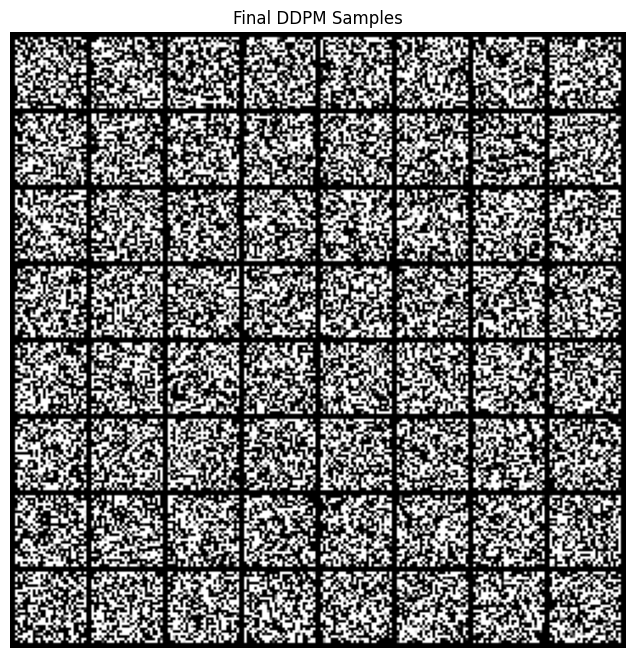

In [11]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# ----------------------------------------
# 9) Final sampling with EMA weights (plot version)
# ----------------------------------------
ema.apply_shadow(model)
model.eval()
with torch.no_grad():
    x = torch.randn(64, num_channels, image_size, image_size, device=device)
    for i in reversed(range(0, num_inference_steps)):
        t_cur = torch.full((x.size(0),), i*(timesteps//num_inference_steps), device=device, dtype=torch.long)
        # predictor
        eps = model(x, t_cur)
        beta = get_index_from_list(betas, t_cur, x.shape)
        sqrt1macp = get_index_from_list(sqrt_one_minus_alphas_cumprod, t_cur, x.shape)
        coeff = beta / sqrt1macp
        x = (1/torch.sqrt(get_index_from_list(alphas, t_cur, x.shape))) * (x - coeff * eps)
        # corrector
        for _ in range(pc_corrector_steps):
            grad = model(x, t_cur)
            noise = torch.randn_like(x)
            scale = torch.sqrt(torch.tensor(2 * pc_gamma, device=x.device))
            x = x + pc_gamma * grad + scale * noise
        # noise injection
        if i > 0:
            var = get_index_from_list(posterior_variance, t_cur, x.shape)
            x = x + torch.sqrt(var) * torch.randn_like(x)

    # Convert tensor to grid
    grid = vutils.make_grid(x.cpu(), nrow=8, normalize=True, value_range=(-1,1))

    # Plot
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0))  # CHW -> HWC
    plt.axis('off')
    plt.title("Final DDPM Samples")
    plt.show()
